# Initialisation

In [1]:
import graphviz
from random import random, randint, seed
from random import uniform as ran_uniform 
from statistics import mean
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import Image, display
from graphviz import Digraph, Source 

# please play with these settings 
pop_size        = 1000   # initial population size
selection_meth  = 'TOURNAMENT' # select either 'TOURNAMENT' or 'ROULETTE'
generations     = 10  # maximal number of generations to run evolution
how_many_primes = 17  # number of primes you want the algorithm to try and generate
create_maxdep   = False # grow or max depth for tree initialisation False = Grow / True = Max Depth
tournament_size = 50    # size of tournament for tournament selection
crossover_rate  = 0.8  # crossover rate 
prob_mutation   = 0.2  # per-node mutation probability
number_of_runs  = 5 # how many runs of the program 

# changing these might break things
MIN_DEPTH       = 2    # minimal initial random tree depth
MAX_DEPTH       = 5    # maximal initial random tree depth  

userinput = list(range(1, how_many_primes +1))

# defining the functions and terminals

def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
FUNCTIONS = [add, sub, mul]
TERMINALS = ['k', 1, 2, 3, 4, 'k', 'k', 'k', 'k', 5, 6, 7, 8, 9, 10] 

# Prime Checker

In [2]:
def is_prime_number(x): # checks to see if a given number is prime
    if x >= 2:
        for y in range(2,x):
            if not ( x % y ):
                return False
    else:
        return False
    return True

# Tree Class

In [3]:
class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree(prefix + "Left   ")
        if self.right: self.right.print_tree(prefix + "Right   ")

    def compute_tree(self, x): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.compute_tree(x), self.right.compute_tree(x))
        elif self.data == 'k': return x
        else: return self.data
            
    def random_tree(self, grow, max_depth, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)

    def mutation(self):
        if random() < prob_mutation: # mutate at this node
            self.random_tree(grow = True, max_depth = 2)
        elif self.left: self.left.mutation()
        elif self.right: self.right.mutation() 

    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r

    def build_subtree(self): # count is list in order to pass "by reference"
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.build_subtree()
        if self.right: t.right = self.right.build_subtree()
        return t
                        
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None              
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)  
            return ret

    def crossover(self, other): # crossover 2 trees at random nodes
        if random() < crossover_rate:
            second = other.scan_tree([randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree
                    
    def draw(self, dot, count): # dot & count are lists in order to pass "by reference" 
        node_name = str(count[0])
        dot[0].node(node_name, self.node_label())
        if self.left:
            count[0] += 1
            dot[0].edge(node_name, str(count[0]))
            self.left.draw(dot, count)
        if self.right:
            count[0] += 1
            dot[0].edge(node_name, str(count[0]))
            self.right.draw(dot, count)
            
    def draw_tree(self, fname, footer):
        dot = [Digraph()]
        dot[0].attr(kw='graph', label = footer)
        count = [0]
        self.draw(dot, count)
        Source(dot[0], filename = fname + ".gv", format="png").render()
        display(Image(filename = fname + ".gv.png"))
        
#end class GPTree

# Tree Population Functions

In [4]:
def init_population(): # initialise population, can either be full or grow
    pop = []
    if create_maxdep == True:
        for md in range(5, MAX_DEPTH + 1):
            for i in range(int(pop_size)):
                t = GPTree()
                t.random_tree(grow = False, max_depth = md) # grow
                pop.append(t) 
    else:
        for md in range(5, MAX_DEPTH + 1):
            for i in range(int(pop_size)):
                t = GPTree()
                t.random_tree(grow = True, max_depth = md) # grow
                pop.append(t) 
    return pop

In [5]:
def population_tree_sizes():
    pop_tree_size = []
    for i in population:
        pop_tree_size.append(GPTree.size(i))
    return pop_tree_size

# gives us the size of each of the trees in the population

In [6]:
def min_pop_tree_size():return str(min(population_tree_sizes()))
def max_pop_tree_size():return str(max(population_tree_sizes()))
def mean_pop_tree_size():return str(mean(population_tree_sizes()))
    
# quick functions to return the sizes of trees in the current population

In [7]:
def population_count():
    count = 0
    for i in population:
        count += 1
    return str(count)

# does a simple count of the current population

In [8]:
def draw_initial_pop():
    tree = 1
    for individual in population:
        print(GPTree.draw_tree(individual, "Header", "Tree " + str(tree)))
        tree += 1
        
# this function allows us to draw the initial bunch of trees

# Raw Fitness Function

In [9]:
def calc_output(k):
    return GPTree.compute_tree(individual, k)

# returns the output of an individual tree for a given value of k 

In [10]:
def tree_check_prime(k):
    return is_prime_number(calc_output(k))

# returns a bool indicating whether the individual tree returns a prime for the specified value of k

In [11]:
def fitness(individual):    
    fitness_num = 0
    for n in range(1000):
        if GPTree.compute_tree(individual, fitness_num) == GPTree.compute_tree(individual, n + 1):
            return fitness_num
        if is_prime_number(GPTree.compute_tree(individual, n)) == True:
            fitness_num += 1
        if is_prime_number(GPTree.compute_tree(individual, n)) == False:
            return fitness_num
        if fitness_num == len(userinput):
            return fitness_num
            break
            
# returns the raw fitness of a given individual tree

In [12]:
def best_of_fitness():    
    fitness_num = 0
    for n in range(1000):
        if is_prime_number(GPTree.compute_tree(best_of_run, n)) == True:
            fitness_num += 1
        if is_prime_number(GPTree.compute_tree(best_of_run, n)) == False:
            return fitness_num
            break
        if fitness_num == len(userinput):
            return fitness_num
            break
            
# returns the fitness of the best of run tree, just to confirm the result

# Adjusted Fitness Function

In [13]:
def adj_fitness_best(): return (1/ (1 + (len(userinput) - best_of_fitness())))

# returns the adjusted fitness for the best of run

# Selection Functions

In [14]:
def selection(population, fitnesses):
    if selection_meth == 'TOURNAMENT': return tournament_selection(population, fitnesses)
    if selection_meth == 'ROULETTE': return roulette_selection(population, fitnesses)
    
# selects the correct selection method depending on the user's selection at the initialisation stage

## Tournament Selection

In [15]:
def tournament_selection(population, fitnesses): 
    tournament = [randint(0, len(population)-1) for i in range(tournament_size)] # select tournament contenders
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(tournament_size)]
    return deepcopy(population[tournament[tournament_fitnesses.index(max(tournament_fitnesses))]]) 

# select one individual using tournament selection

## Roulette Selection

In [16]:
def roulette_selection(population, fitnesses): 
        #max_fit = max(fitnesses)
        max_fit = how_many_primes
        pick    = ran_uniform(0, max_fit)
        current = 0
        for individual in population:
            current += fitness(individual)
            if current > pick:
                return deepcopy(individual)
# select one individual using roulette selection

In [17]:
def percentage_pop_are_prime_generators():
    return ((int(population_count()) - fitnesses.count(0))/int(population_count()))*100

# calculates the percentage of the population that generates a prime number from the first value of K 

# Validator

In [18]:
def best_of_run_validate():
    for num in range(len(userinput)):
        validator = 0
        if is_prime_number(GPTree.compute_tree(best_of_run, num)) == True:
            validator += 1
        print ("k = " + str(num) + " produces " + str(GPTree.compute_tree(best_of_run, num)) + " prime = "+ str(is_prime_number(GPTree.compute_tree(best_of_run, num))))
        if is_prime_number(GPTree.compute_tree(best_of_run, num)) == False:
            break

# simple validator to allow the checking of that the prime sequence generated by the best of run is valid 

# Run Plot & Run Info

In [19]:
def run_plot():

    plt.plot(range(len(raw_fitnesses)), raw_fitnesses, label="Fitness")
    plt.plot(range(len(raw_fitnesses)), best_of_gen, label="Generation")
    plt.xlabel("Run number of " + str(len(raw_fitnesses)) + "\nUsed " + selection_meth + " selection method")
    plt.ylabel("Number")
    plt.legend(loc=6, bbox_to_anchor=(0.4, 0.8, 0.5, 0.5))
    plt.savefig('chart.png', dpi=200, pad=3)
    plt.figure(figsize = (15,15))

# produces a line plot of the longest prime sequence and which generation it was produced across multiple runs

In [20]:
def run_info():
    print("_________________________________________________")
    print("\n.:: Run Info ::.")
    print("Run used " + selection_meth + " selection method")
    print("Starting population was " + population_count())
    print("Program was run " + str(len(raw_fitnesses)) + " times with " + str(generations) + " generations per run")
    print("Percentage of runs that generated the full list of " + str(how_many_primes) + " primes " + str(round((raw_fitnesses.count(how_many_primes)/len(raw_fitnesses))*100,2)) + "%")
    print("Mean best of run occurance was in generation " + str(round(mean(best_of_gen),2)))
    if (len(raw_fitnesses)) >=5:
        run_plot()

# prints run stats and plots a line graph if there are over 5 runs completed

# Main Program

In [21]:
raw_fitnesses = []
best_of_gen = []

.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 41
Mean tree size is 18.722
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding program ::.
Generation: 0 Best fitness so far: 6
Generation: 1 Best fitness so far: 11
Generation: 5 Best fitness so far: 16
Generation: 9 Best fitness so far: 17
_________________________________________________
END OF BREEDING PROGRAM
The best run was attained at generation 9 and has a raw fitness of 17 out of 17
Program ran for 10 generations


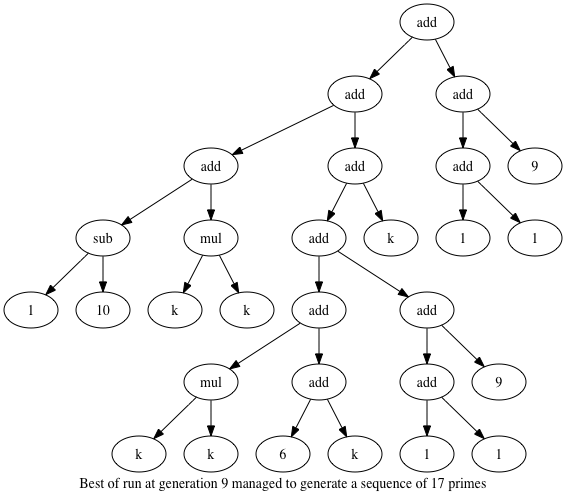

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.842
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 9.2%

.:: Starting breeding program

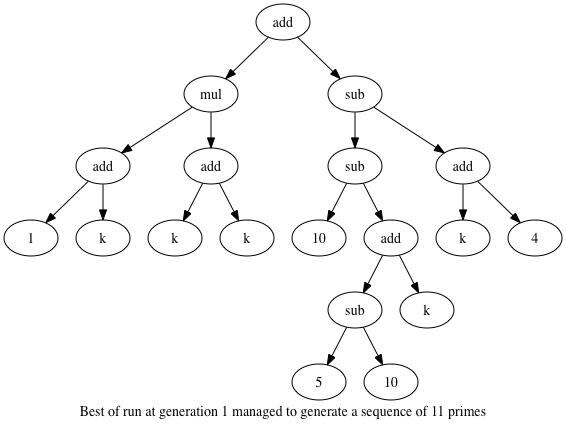

k = 0 produces 11 prime = True
k = 1 produces 13 prime = True
k = 2 produces 19 prime = True
k = 3 produces 29 prime = True
k = 4 produces 43 prime = True
k = 5 produces 61 prime = True
k = 6 produces 83 prime = True
k = 7 produces 109 prime = True
k = 8 produces 139 prime = True
k = 9 produces 173 prime = True
k = 10 produces 211 prime = True
k = 11 produces 253 prime = False

Confirmed raw fitness is 11

Adjusted fitness of best is 0.14/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.426
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding program ::.
Generation: 0 Best fitness so far: 10
Generation: 2 Best fitness so far: 15
Generation: 4 Best fitness so far: 17
_____________________________________________

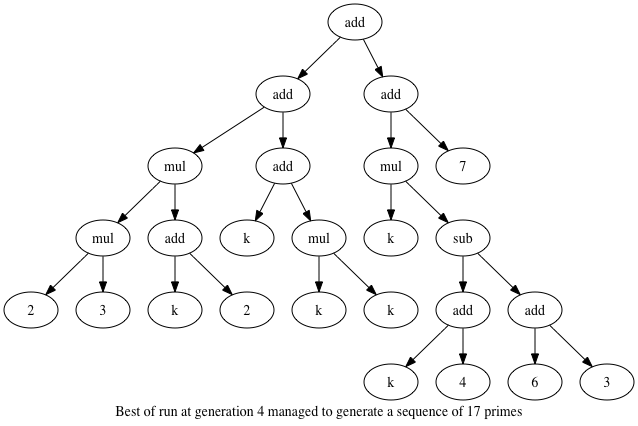

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 19.122
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 7.8%

.:: Starting breeding program

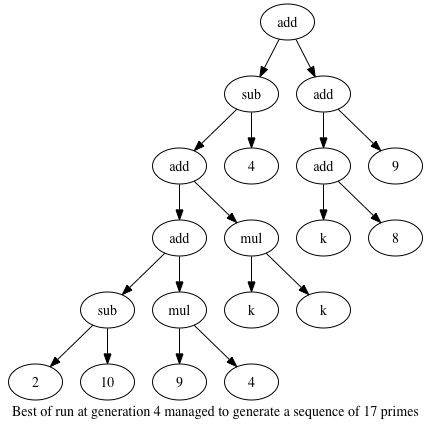

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.784
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.3%

.:: Starting breeding program :

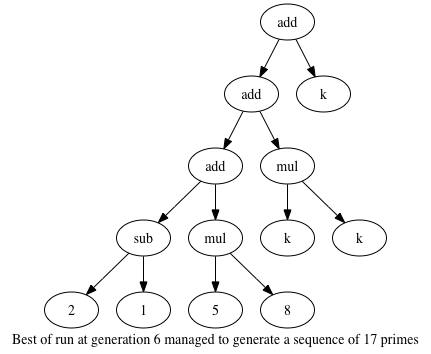

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.718
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.3%

.:: Starting breeding program :

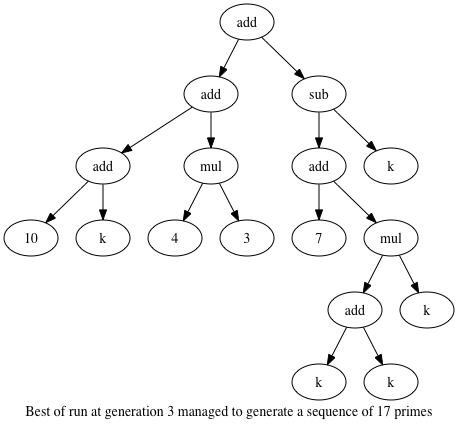

k = 0 produces 29 prime = True
k = 1 produces 31 prime = True
k = 2 produces 37 prime = True
k = 3 produces 47 prime = True
k = 4 produces 61 prime = True
k = 5 produces 79 prime = True
k = 6 produces 101 prime = True
k = 7 produces 127 prime = True
k = 8 produces 157 prime = True
k = 9 produces 191 prime = True
k = 10 produces 229 prime = True
k = 11 produces 271 prime = True
k = 12 produces 317 prime = True
k = 13 produces 367 prime = True
k = 14 produces 421 prime = True
k = 15 produces 479 prime = True
k = 16 produces 541 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.806
Longest prime sequence of inital population = 6
Percentage of initial population that generate a prime from first k value = 10.6%

.:: Starting breeding progra

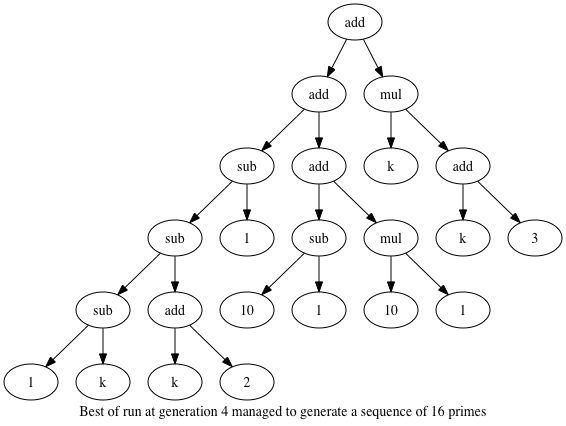

k = 0 produces 17 prime = True
k = 1 produces 19 prime = True
k = 2 produces 23 prime = True
k = 3 produces 29 prime = True
k = 4 produces 37 prime = True
k = 5 produces 47 prime = True
k = 6 produces 59 prime = True
k = 7 produces 73 prime = True
k = 8 produces 89 prime = True
k = 9 produces 107 prime = True
k = 10 produces 127 prime = True
k = 11 produces 149 prime = True
k = 12 produces 173 prime = True
k = 13 produces 199 prime = True
k = 14 produces 227 prime = True
k = 15 produces 257 prime = True
k = 16 produces 289 prime = False

Confirmed raw fitness is 16

Adjusted fitness of best is 0.5/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.208
Longest prime sequence of inital population = 17
Percentage of initial population that generate a prime from first k value = 10.100000000000001%

.:: Starting br

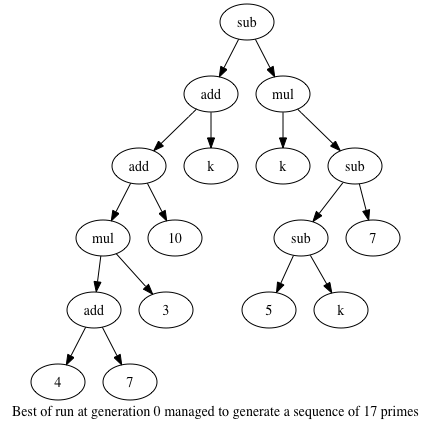

k = 0 produces 43 prime = True
k = 1 produces 47 prime = True
k = 2 produces 53 prime = True
k = 3 produces 61 prime = True
k = 4 produces 71 prime = True
k = 5 produces 83 prime = True
k = 6 produces 97 prime = True
k = 7 produces 113 prime = True
k = 8 produces 131 prime = True
k = 9 produces 151 prime = True
k = 10 produces 173 prime = True
k = 11 produces 197 prime = True
k = 12 produces 223 prime = True
k = 13 produces 251 prime = True
k = 14 produces 281 prime = True
k = 15 produces 313 prime = True
k = 16 produces 347 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 41
Mean tree size is 19.1
Longest prime sequence of inital population = 8
Percentage of initial population that generate a prime from first k value = 9.2%

.:: Starting breeding program ::

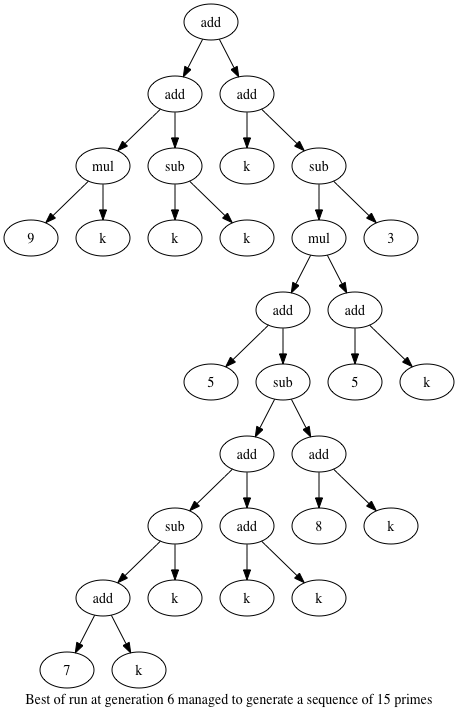

k = 0 produces 17 prime = True
k = 1 produces 37 prime = True
k = 2 produces 59 prime = True
k = 3 produces 83 prime = True
k = 4 produces 109 prime = True
k = 5 produces 137 prime = True
k = 6 produces 167 prime = True
k = 7 produces 199 prime = True
k = 8 produces 233 prime = True
k = 9 produces 269 prime = True
k = 10 produces 307 prime = True
k = 11 produces 347 prime = True
k = 12 produces 389 prime = True
k = 13 produces 433 prime = True
k = 14 produces 479 prime = True
k = 15 produces 527 prime = False

Confirmed raw fitness is 15

Adjusted fitness of best is 0.33/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.95
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 8.4%

.:: Starting breeding program ::.
Generation: 0 Best fitnes

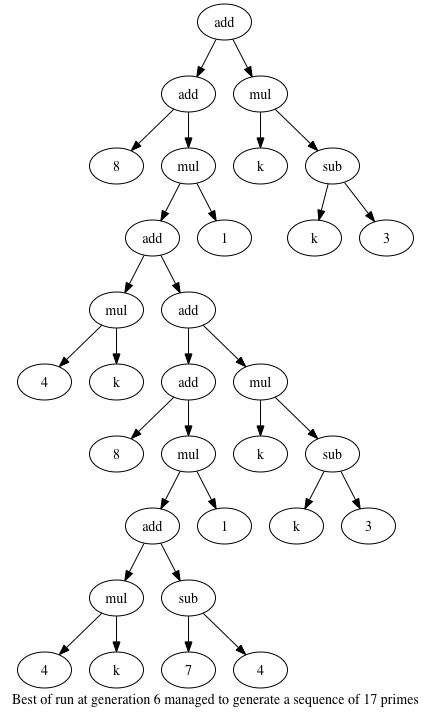

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.892
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 6.7%

.:: Starting breeding program

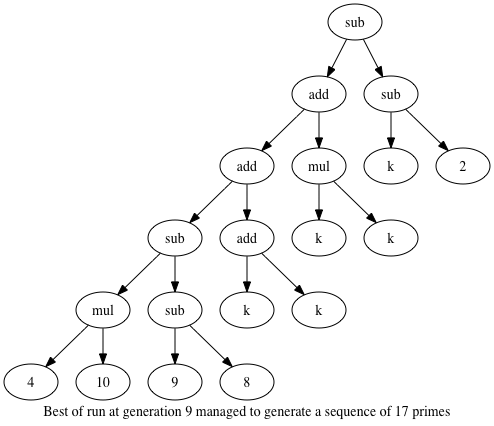

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.128
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.3%

.:: Starting breeding program :

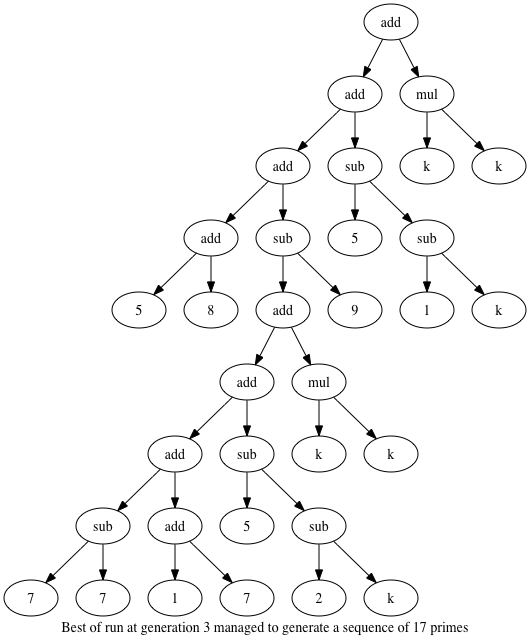

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.896
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.9%

.:: Starting breeding program

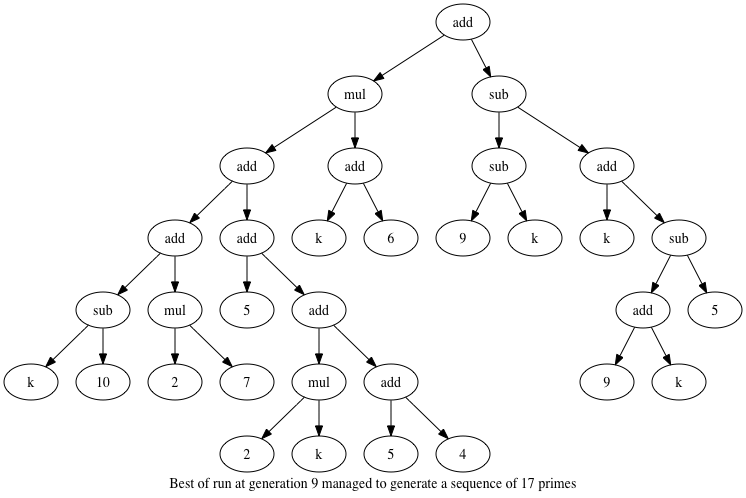

k = 0 produces 113 prime = True
k = 1 produces 149 prime = True
k = 2 produces 191 prime = True
k = 3 produces 239 prime = True
k = 4 produces 293 prime = True
k = 5 produces 353 prime = True
k = 6 produces 419 prime = True
k = 7 produces 491 prime = True
k = 8 produces 569 prime = True
k = 9 produces 653 prime = True
k = 10 produces 743 prime = True
k = 11 produces 839 prime = True
k = 12 produces 941 prime = True
k = 13 produces 1049 prime = True
k = 14 produces 1163 prime = True
k = 15 produces 1283 prime = True
k = 16 produces 1409 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 51
Mean tree size is 19.262
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.9%

.:: Starting breedi

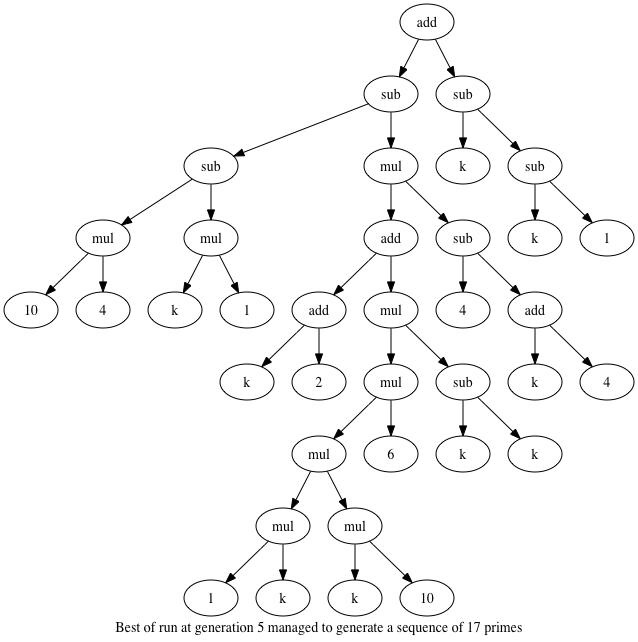

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.756
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 8.6%

.:: Starting breeding program :

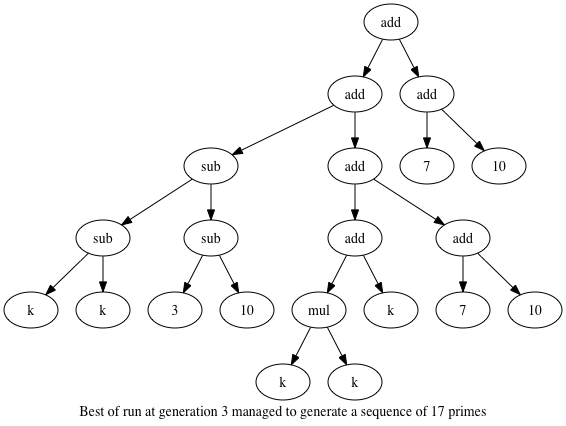

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.862
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.9%

.:: Starting breeding program :

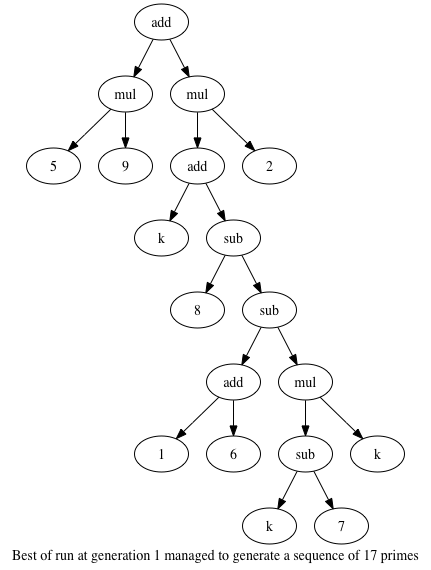

k = 0 produces 47 prime = True
k = 1 produces 37 prime = True
k = 2 produces 31 prime = True
k = 3 produces 29 prime = True
k = 4 produces 31 prime = True
k = 5 produces 37 prime = True
k = 6 produces 47 prime = True
k = 7 produces 61 prime = True
k = 8 produces 79 prime = True
k = 9 produces 101 prime = True
k = 10 produces 127 prime = True
k = 11 produces 157 prime = True
k = 12 produces 191 prime = True
k = 13 produces 229 prime = True
k = 14 produces 271 prime = True
k = 15 produces 317 prime = True
k = 16 produces 367 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.944
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.4%

.:: Starting breeding program ::

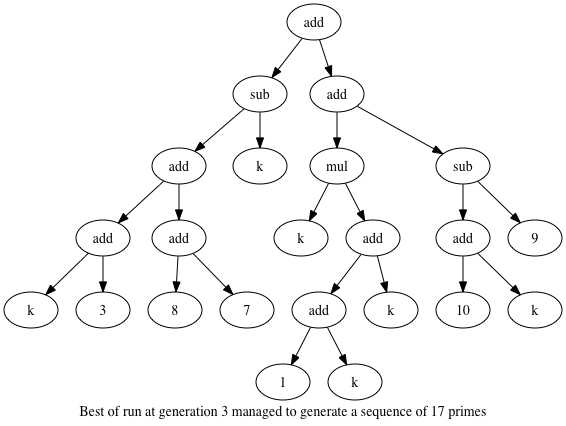

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.91
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.1%

.:: Starting breeding program 

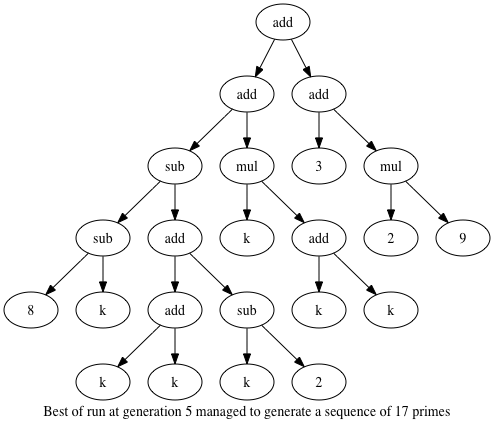

k = 0 produces 31 prime = True
k = 1 produces 29 prime = True
k = 2 produces 31 prime = True
k = 3 produces 37 prime = True
k = 4 produces 47 prime = True
k = 5 produces 61 prime = True
k = 6 produces 79 prime = True
k = 7 produces 101 prime = True
k = 8 produces 127 prime = True
k = 9 produces 157 prime = True
k = 10 produces 191 prime = True
k = 11 produces 229 prime = True
k = 12 produces 271 prime = True
k = 13 produces 317 prime = True
k = 14 produces 367 prime = True
k = 15 produces 421 prime = True
k = 16 produces 479 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.572
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 7.7%

.:: Starting breeding program 

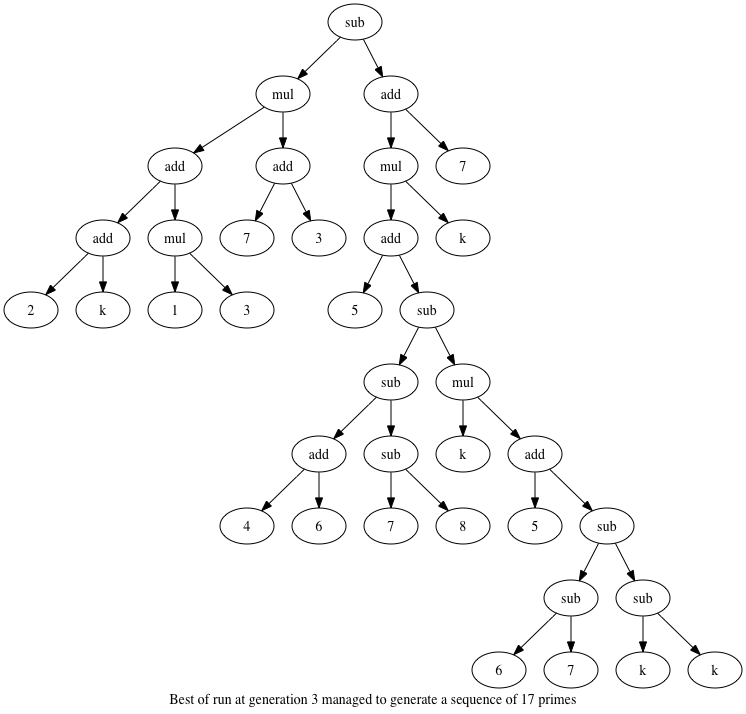

k = 0 produces 43 prime = True
k = 1 produces 41 prime = True
k = 2 produces 47 prime = True
k = 3 produces 61 prime = True
k = 4 produces 83 prime = True
k = 5 produces 113 prime = True
k = 6 produces 151 prime = True
k = 7 produces 197 prime = True
k = 8 produces 251 prime = True
k = 9 produces 313 prime = True
k = 10 produces 383 prime = True
k = 11 produces 461 prime = True
k = 12 produces 547 prime = True
k = 13 produces 641 prime = True
k = 14 produces 743 prime = True
k = 15 produces 853 prime = True
k = 16 produces 971 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.926
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.7%

.:: Starting breeding progra

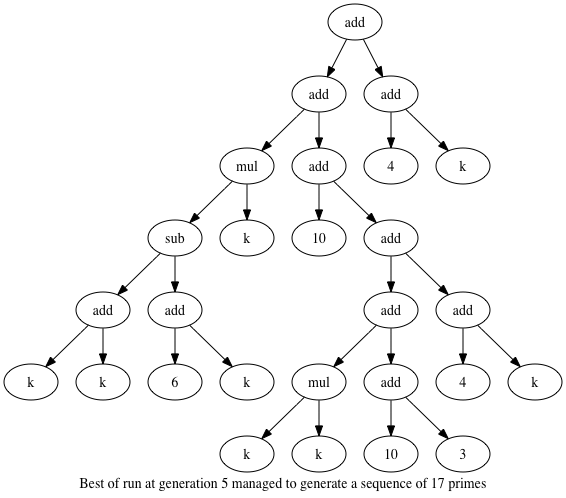

k = 0 produces 31 prime = True
k = 1 produces 29 prime = True
k = 2 produces 31 prime = True
k = 3 produces 37 prime = True
k = 4 produces 47 prime = True
k = 5 produces 61 prime = True
k = 6 produces 79 prime = True
k = 7 produces 101 prime = True
k = 8 produces 127 prime = True
k = 9 produces 157 prime = True
k = 10 produces 191 prime = True
k = 11 produces 229 prime = True
k = 12 produces 271 prime = True
k = 13 produces 317 prime = True
k = 14 produces 367 prime = True
k = 15 produces 421 prime = True
k = 16 produces 479 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 51
Mean tree size is 19.196
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.0%

.:: Starting breeding program 

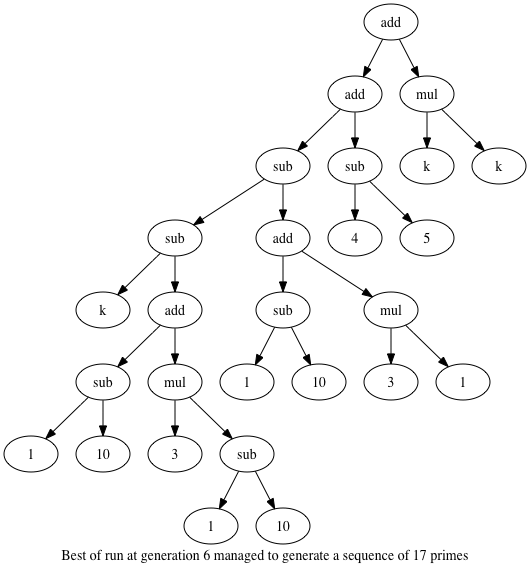

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.882
Longest prime sequence of inital population = 6
Percentage of initial population that generate a prime from first k value = 7.6%

.:: Starting breeding program :

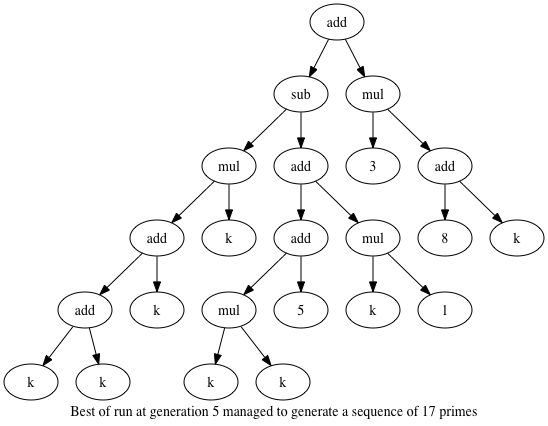

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.854
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 7.3999999999999995%

.:: Starting b

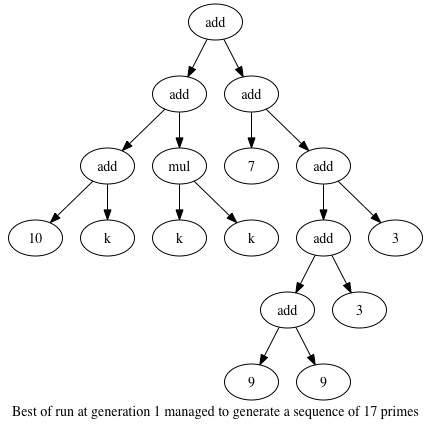

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.116
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.5%

.:: Starting breeding program :

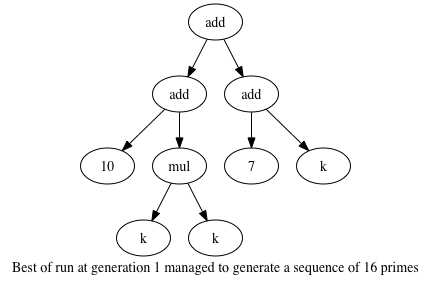

k = 0 produces 17 prime = True
k = 1 produces 19 prime = True
k = 2 produces 23 prime = True
k = 3 produces 29 prime = True
k = 4 produces 37 prime = True
k = 5 produces 47 prime = True
k = 6 produces 59 prime = True
k = 7 produces 73 prime = True
k = 8 produces 89 prime = True
k = 9 produces 107 prime = True
k = 10 produces 127 prime = True
k = 11 produces 149 prime = True
k = 12 produces 173 prime = True
k = 13 produces 199 prime = True
k = 14 produces 227 prime = True
k = 15 produces 257 prime = True
k = 16 produces 289 prime = False

Confirmed raw fitness is 16

Adjusted fitness of best is 0.5/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 19.276
Longest prime sequence of inital population = 14
Percentage of initial population that generate a prime from first k value = 8.1%

.:: Starting breeding program 

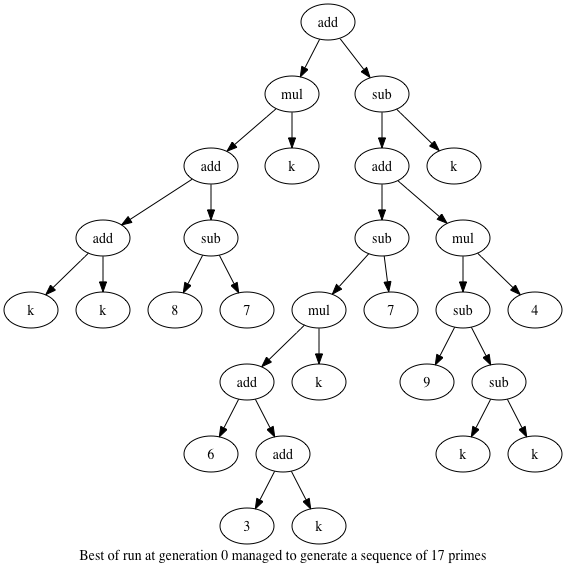

k = 0 produces 29 prime = True
k = 1 produces 41 prime = True
k = 2 produces 59 prime = True
k = 3 produces 83 prime = True
k = 4 produces 113 prime = True
k = 5 produces 149 prime = True
k = 6 produces 191 prime = True
k = 7 produces 239 prime = True
k = 8 produces 293 prime = True
k = 9 produces 353 prime = True
k = 10 produces 419 prime = True
k = 11 produces 491 prime = True
k = 12 produces 569 prime = True
k = 13 produces 653 prime = True
k = 14 produces 743 prime = True
k = 15 produces 839 prime = True
k = 16 produces 941 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 19.068
Longest prime sequence of inital population = 6
Percentage of initial population that generate a prime from first k value = 9.2%

.:: Starting breeding progr

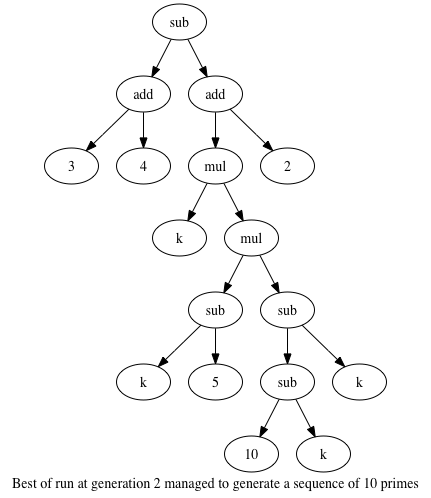

k = 0 produces 5 prime = True
k = 1 produces 37 prime = True
k = 2 produces 41 prime = True
k = 3 produces 29 prime = True
k = 4 produces 13 prime = True
k = 5 produces 5 prime = True
k = 6 produces 17 prime = True
k = 7 produces 61 prime = True
k = 8 produces 149 prime = True
k = 9 produces 293 prime = True
k = 10 produces 505 prime = False

Confirmed raw fitness is 10

Adjusted fitness of best is 0.12/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 41
Mean tree size is 19
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 10.299999999999999%

.:: Starting breeding program ::.
Generation: 0 Best fitness so far: 8
Generation: 3 Best fitness so far: 12
Generation: 4 Best fitness so far: 17
_________________________________________________
END OF BREEDING PROGR

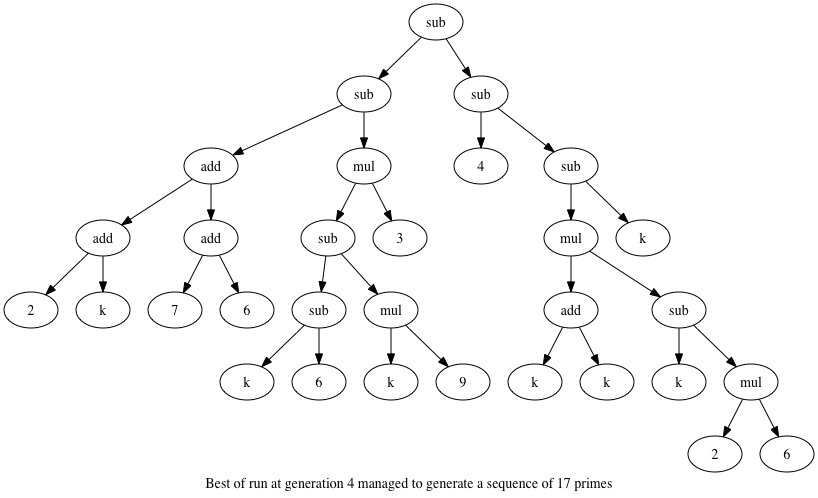

k = 0 produces 29 prime = True
k = 1 produces 31 prime = True
k = 2 produces 37 prime = True
k = 3 produces 47 prime = True
k = 4 produces 61 prime = True
k = 5 produces 79 prime = True
k = 6 produces 101 prime = True
k = 7 produces 127 prime = True
k = 8 produces 157 prime = True
k = 9 produces 191 prime = True
k = 10 produces 229 prime = True
k = 11 produces 271 prime = True
k = 12 produces 317 prime = True
k = 13 produces 367 prime = True
k = 14 produces 421 prime = True
k = 15 produces 479 prime = True
k = 16 produces 541 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.944
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.9%

.:: Starting breeding program

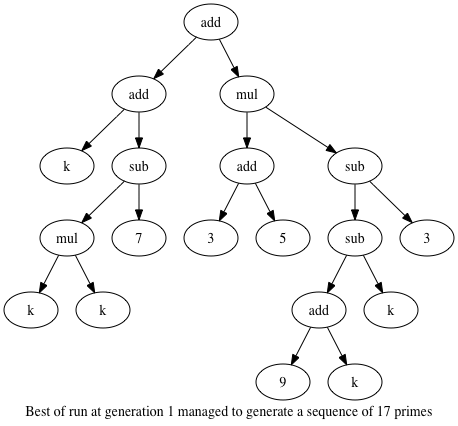

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.606
Longest prime sequence of inital population = 16
Percentage of initial population that generate a prime from first k value = 9.6%

.:: Starting breeding program 

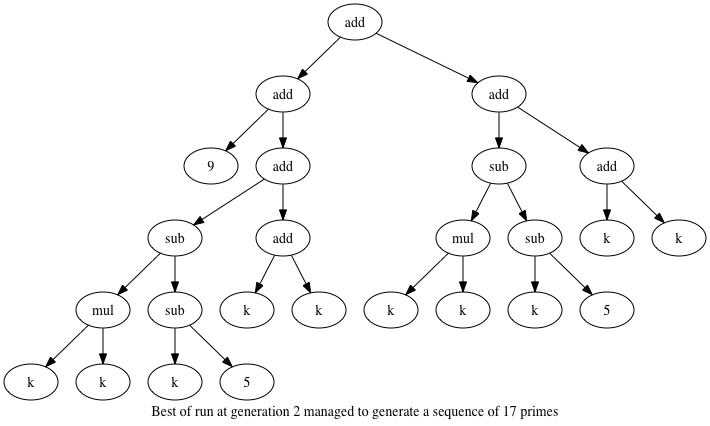

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.99
Longest prime sequence of inital population = 16
Percentage of initial population that generate a prime from first k value = 9.5%

.:: Starting breeding program

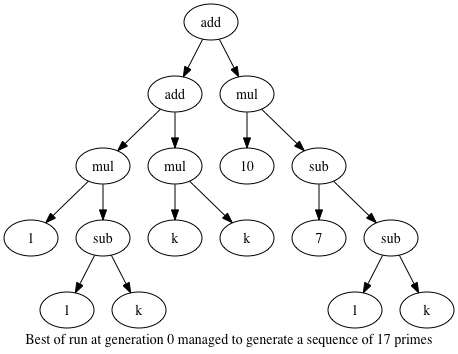

k = 0 produces 61 prime = True
k = 1 produces 71 prime = True
k = 2 produces 83 prime = True
k = 3 produces 97 prime = True
k = 4 produces 113 prime = True
k = 5 produces 131 prime = True
k = 6 produces 151 prime = True
k = 7 produces 173 prime = True
k = 8 produces 197 prime = True
k = 9 produces 223 prime = True
k = 10 produces 251 prime = True
k = 11 produces 281 prime = True
k = 12 produces 313 prime = True
k = 13 produces 347 prime = True
k = 14 produces 383 prime = True
k = 15 produces 421 prime = True
k = 16 produces 461 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 51
Mean tree size is 19.012
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.5%

.:: Starting breeding progr

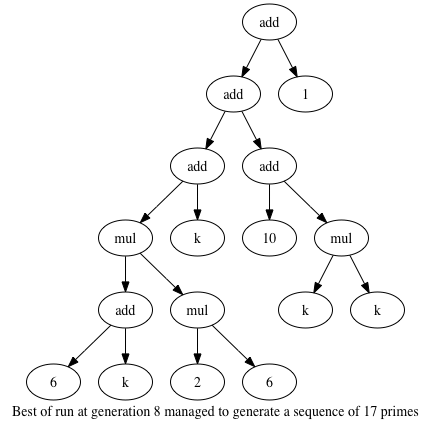

k = 0 produces 83 prime = True
k = 1 produces 97 prime = True
k = 2 produces 113 prime = True
k = 3 produces 131 prime = True
k = 4 produces 151 prime = True
k = 5 produces 173 prime = True
k = 6 produces 197 prime = True
k = 7 produces 223 prime = True
k = 8 produces 251 prime = True
k = 9 produces 281 prime = True
k = 10 produces 313 prime = True
k = 11 produces 347 prime = True
k = 12 produces 383 prime = True
k = 13 produces 421 prime = True
k = 14 produces 461 prime = True
k = 15 produces 503 prime = True
k = 16 produces 547 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.832
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 9.0%

.:: Starting breeding pro

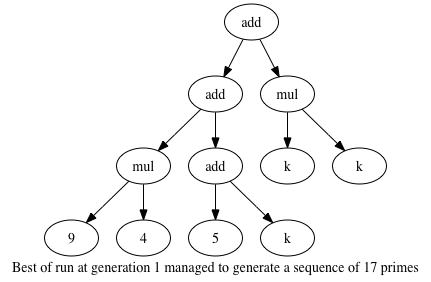

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.96
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 8.1%

.:: Starting breeding program ::

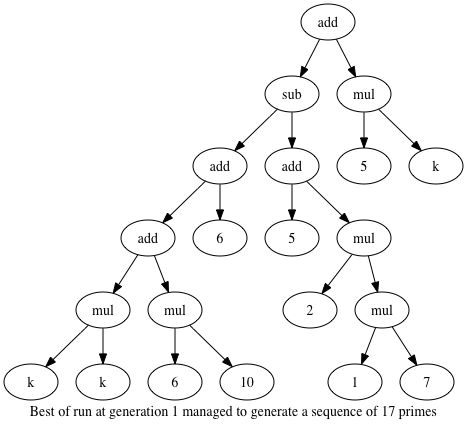

k = 0 produces 47 prime = True
k = 1 produces 53 prime = True
k = 2 produces 61 prime = True
k = 3 produces 71 prime = True
k = 4 produces 83 prime = True
k = 5 produces 97 prime = True
k = 6 produces 113 prime = True
k = 7 produces 131 prime = True
k = 8 produces 151 prime = True
k = 9 produces 173 prime = True
k = 10 produces 197 prime = True
k = 11 produces 223 prime = True
k = 12 produces 251 prime = True
k = 13 produces 281 prime = True
k = 14 produces 313 prime = True
k = 15 produces 347 prime = True
k = 16 produces 383 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.7
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 10.5%

.:: Starting breeding program 

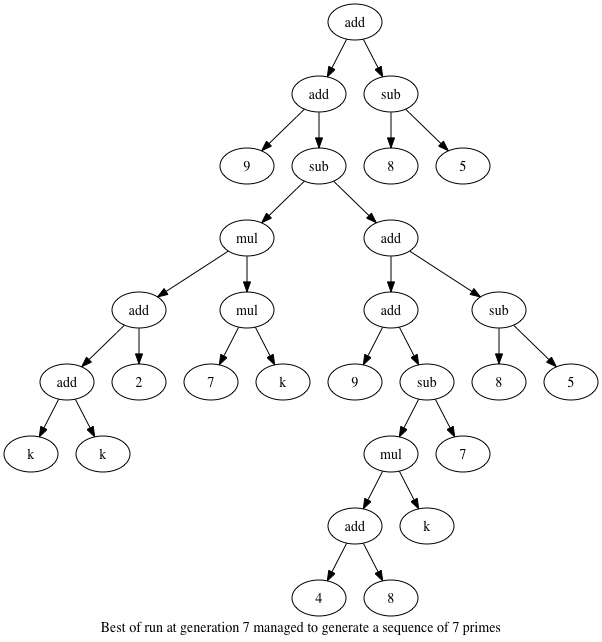

k = 0 produces 7 prime = True
k = 1 produces 23 prime = True
k = 2 produces 67 prime = True
k = 3 produces 139 prime = True
k = 4 produces 239 prime = True
k = 5 produces 367 prime = True
k = 6 produces 523 prime = True
k = 7 produces 707 prime = False

Confirmed raw fitness is 7

Adjusted fitness of best is 0.09/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 19.106
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 11.4%

.:: Starting breeding program ::.
Generation: 0 Best fitness so far: 5
Generation: 4 Best fitness so far: 7
Generation: 6 Best fitness so far: 16
_________________________________________________
END OF BREEDING PROGRAM
The best run was attained at generation 6 and has a raw fitness of 16 out of 17
Program ran for 10 g

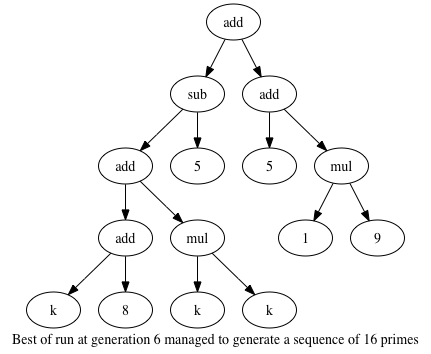

k = 0 produces 17 prime = True
k = 1 produces 19 prime = True
k = 2 produces 23 prime = True
k = 3 produces 29 prime = True
k = 4 produces 37 prime = True
k = 5 produces 47 prime = True
k = 6 produces 59 prime = True
k = 7 produces 73 prime = True
k = 8 produces 89 prime = True
k = 9 produces 107 prime = True
k = 10 produces 127 prime = True
k = 11 produces 149 prime = True
k = 12 produces 173 prime = True
k = 13 produces 199 prime = True
k = 14 produces 227 prime = True
k = 15 produces 257 prime = True
k = 16 produces 289 prime = False

Confirmed raw fitness is 16

Adjusted fitness of best is 0.5/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.904
Longest prime sequence of inital population = 16
Percentage of initial population that generate a prime from first k value = 10.6%

.:: Starting breeding program

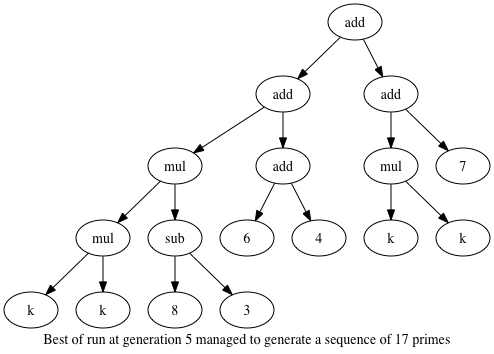

k = 0 produces 17 prime = True
k = 1 produces 23 prime = True
k = 2 produces 41 prime = True
k = 3 produces 71 prime = True
k = 4 produces 113 prime = True
k = 5 produces 167 prime = True
k = 6 produces 233 prime = True
k = 7 produces 311 prime = True
k = 8 produces 401 prime = True
k = 9 produces 503 prime = True
k = 10 produces 617 prime = True
k = 11 produces 743 prime = True
k = 12 produces 881 prime = True
k = 13 produces 1031 prime = True
k = 14 produces 1193 prime = True
k = 15 produces 1367 prime = True
k = 16 produces 1553 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.686
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.700000000000001%

.:: Start

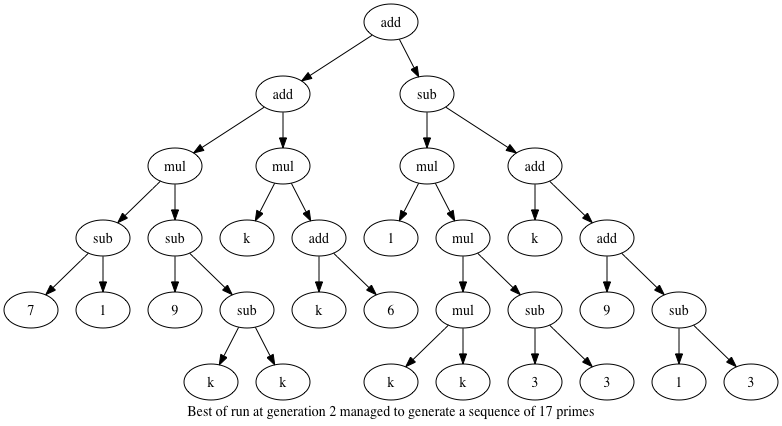

k = 0 produces 47 prime = True
k = 1 produces 53 prime = True
k = 2 produces 61 prime = True
k = 3 produces 71 prime = True
k = 4 produces 83 prime = True
k = 5 produces 97 prime = True
k = 6 produces 113 prime = True
k = 7 produces 131 prime = True
k = 8 produces 151 prime = True
k = 9 produces 173 prime = True
k = 10 produces 197 prime = True
k = 11 produces 223 prime = True
k = 12 produces 251 prime = True
k = 13 produces 281 prime = True
k = 14 produces 313 prime = True
k = 15 produces 347 prime = True
k = 16 produces 383 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 18.69
Longest prime sequence of inital population = 6
Percentage of initial population that generate a prime from first k value = 8.799999999999999%

.:: Starting bre

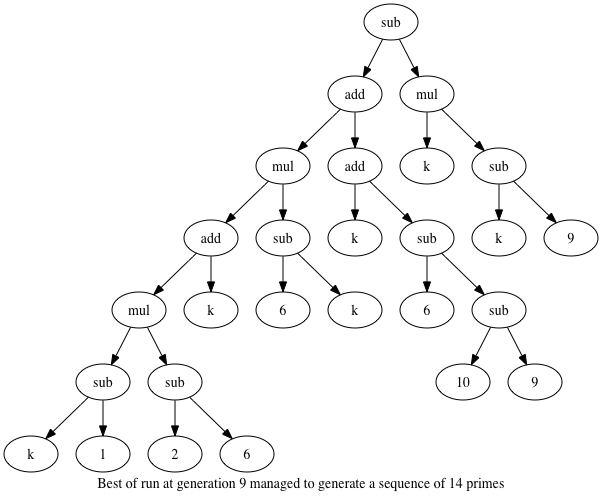

k = 0 produces 29 prime = True
k = 1 produces 19 prime = True
k = 2 produces 13 prime = True
k = 3 produces 11 prime = True
k = 4 produces 13 prime = True
k = 5 produces 19 prime = True
k = 6 produces 29 prime = True
k = 7 produces 43 prime = True
k = 8 produces 61 prime = True
k = 9 produces 83 prime = True
k = 10 produces 109 prime = True
k = 11 produces 139 prime = True
k = 12 produces 173 prime = True
k = 13 produces 211 prime = True
k = 14 produces 253 prime = False

Confirmed raw fitness is 14

Adjusted fitness of best is 0.25/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.666
Longest prime sequence of inital population = 10
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding program ::.
Generation: 0 Best fitness so far: 10
Generation: 1 Best fitne

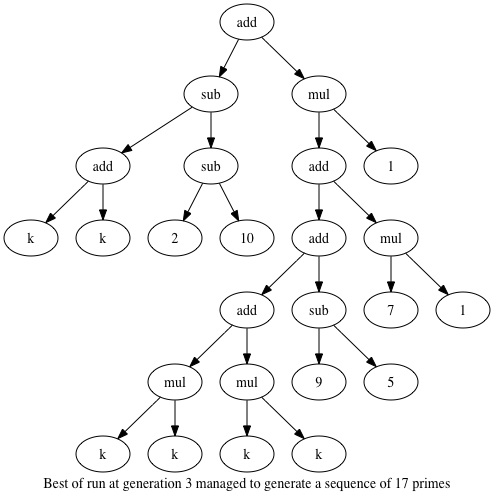

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 19.024
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 10.299999999999999%

.:: Starting b

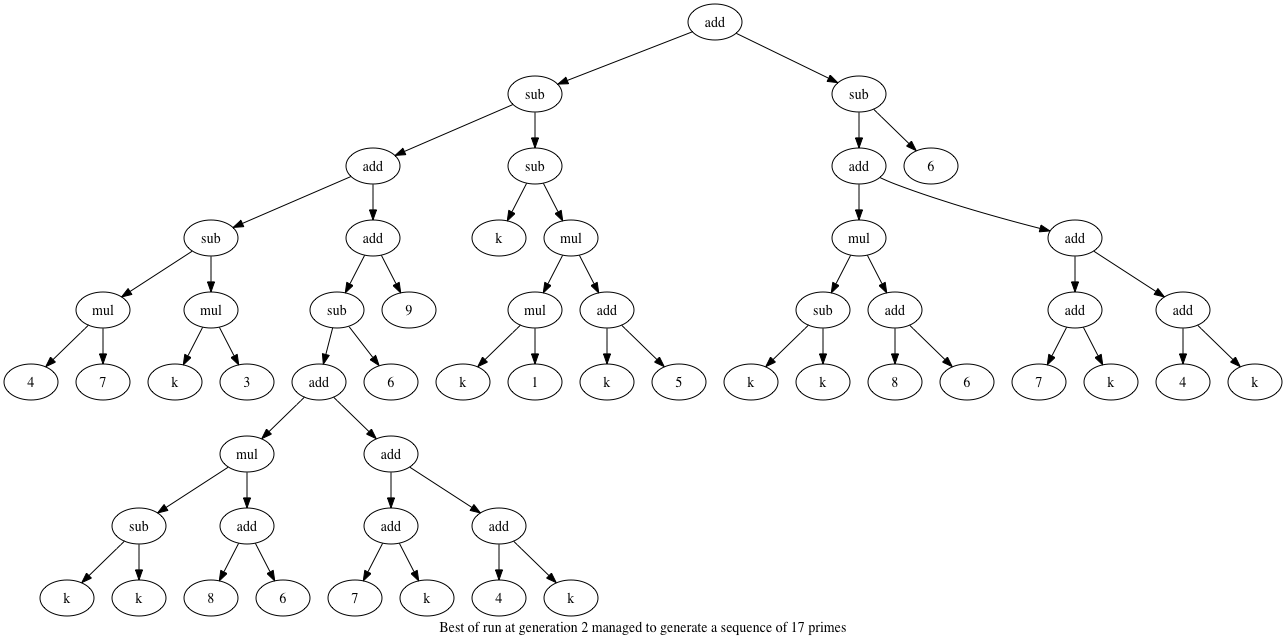

k = 0 produces 47 prime = True
k = 1 produces 53 prime = True
k = 2 produces 61 prime = True
k = 3 produces 71 prime = True
k = 4 produces 83 prime = True
k = 5 produces 97 prime = True
k = 6 produces 113 prime = True
k = 7 produces 131 prime = True
k = 8 produces 151 prime = True
k = 9 produces 173 prime = True
k = 10 produces 197 prime = True
k = 11 produces 223 prime = True
k = 12 produces 251 prime = True
k = 13 produces 281 prime = True
k = 14 produces 313 prime = True
k = 15 produces 347 prime = True
k = 16 produces 383 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 19.246
Longest prime sequence of inital population = 13
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding progra

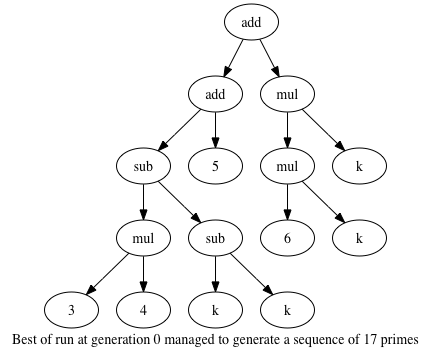

k = 0 produces 17 prime = True
k = 1 produces 23 prime = True
k = 2 produces 41 prime = True
k = 3 produces 71 prime = True
k = 4 produces 113 prime = True
k = 5 produces 167 prime = True
k = 6 produces 233 prime = True
k = 7 produces 311 prime = True
k = 8 produces 401 prime = True
k = 9 produces 503 prime = True
k = 10 produces 617 prime = True
k = 11 produces 743 prime = True
k = 12 produces 881 prime = True
k = 13 produces 1031 prime = True
k = 14 produces 1193 prime = True
k = 15 produces 1367 prime = True
k = 16 produces 1553 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.102
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 8.5%

.:: Starting breeding p

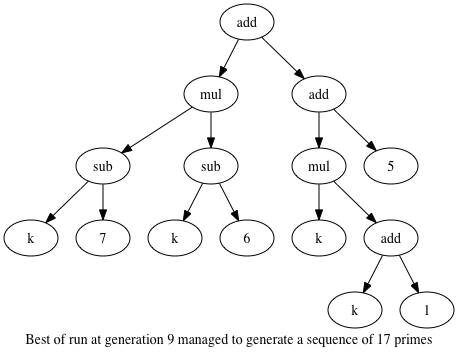

k = 0 produces 47 prime = True
k = 1 produces 37 prime = True
k = 2 produces 31 prime = True
k = 3 produces 29 prime = True
k = 4 produces 31 prime = True
k = 5 produces 37 prime = True
k = 6 produces 47 prime = True
k = 7 produces 61 prime = True
k = 8 produces 79 prime = True
k = 9 produces 101 prime = True
k = 10 produces 127 prime = True
k = 11 produces 157 prime = True
k = 12 produces 191 prime = True
k = 13 produces 229 prime = True
k = 14 produces 271 prime = True
k = 15 produces 317 prime = True
k = 16 produces 367 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 53
Mean tree size is 19.288
Longest prime sequence of inital population = 17
Percentage of initial population that generate a prime from first k value = 9.700000000000001%

.:: Starting bree

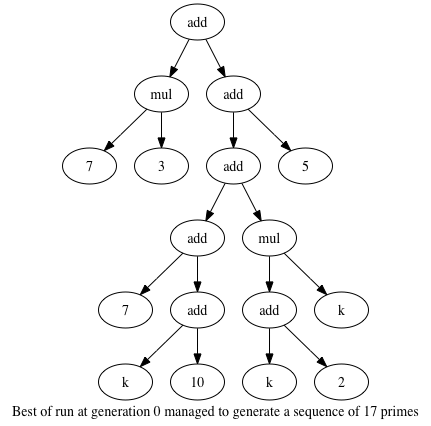

k = 0 produces 43 prime = True
k = 1 produces 47 prime = True
k = 2 produces 53 prime = True
k = 3 produces 61 prime = True
k = 4 produces 71 prime = True
k = 5 produces 83 prime = True
k = 6 produces 97 prime = True
k = 7 produces 113 prime = True
k = 8 produces 131 prime = True
k = 9 produces 151 prime = True
k = 10 produces 173 prime = True
k = 11 produces 197 prime = True
k = 12 produces 223 prime = True
k = 13 produces 251 prime = True
k = 14 produces 281 prime = True
k = 15 produces 313 prime = True
k = 16 produces 347 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19.152
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.1%

.:: Starting breeding program 

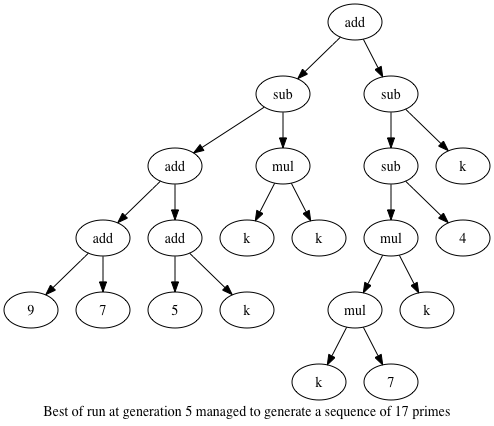

k = 0 produces 17 prime = True
k = 1 produces 23 prime = True
k = 2 produces 41 prime = True
k = 3 produces 71 prime = True
k = 4 produces 113 prime = True
k = 5 produces 167 prime = True
k = 6 produces 233 prime = True
k = 7 produces 311 prime = True
k = 8 produces 401 prime = True
k = 9 produces 503 prime = True
k = 10 produces 617 prime = True
k = 11 produces 743 prime = True
k = 12 produces 881 prime = True
k = 13 produces 1031 prime = True
k = 14 produces 1193 prime = True
k = 15 produces 1367 prime = True
k = 16 produces 1553 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 43
Mean tree size is 18.952
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 10.2%

.:: Starting breeding 

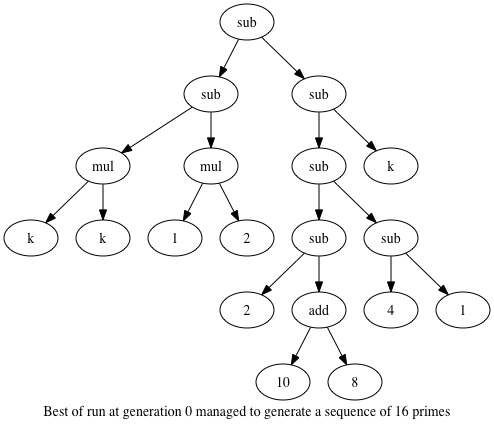

k = 0 produces 17 prime = True
k = 1 produces 19 prime = True
k = 2 produces 23 prime = True
k = 3 produces 29 prime = True
k = 4 produces 37 prime = True
k = 5 produces 47 prime = True
k = 6 produces 59 prime = True
k = 7 produces 73 prime = True
k = 8 produces 89 prime = True
k = 9 produces 107 prime = True
k = 10 produces 127 prime = True
k = 11 produces 149 prime = True
k = 12 produces 173 prime = True
k = 13 produces 199 prime = True
k = 14 produces 227 prime = True
k = 15 produces 257 prime = True
k = 16 produces 289 prime = False

Confirmed raw fitness is 16

Adjusted fitness of best is 0.5/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 45
Mean tree size is 19
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 10.299999999999999%

.:: Starting breedin

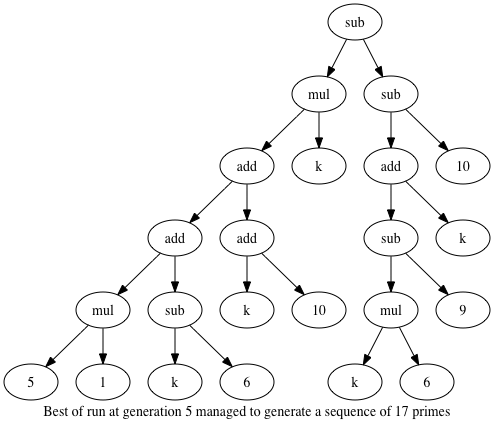

k = 0 produces 19 prime = True
k = 1 produces 23 prime = True
k = 2 produces 31 prime = True
k = 3 produces 43 prime = True
k = 4 produces 59 prime = True
k = 5 produces 79 prime = True
k = 6 produces 103 prime = True
k = 7 produces 131 prime = True
k = 8 produces 163 prime = True
k = 9 produces 199 prime = True
k = 10 produces 239 prime = True
k = 11 produces 283 prime = True
k = 12 produces 331 prime = True
k = 13 produces 383 prime = True
k = 14 produces 439 prime = True
k = 15 produces 499 prime = True
k = 16 produces 563 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 41
Mean tree size is 18.98
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 9.9%

.:: Starting breeding program 

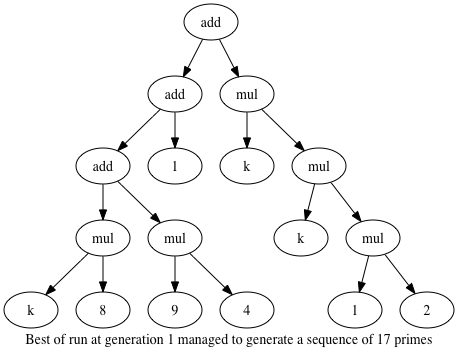

k = 0 produces 37 prime = True
k = 1 produces 47 prime = True
k = 2 produces 61 prime = True
k = 3 produces 79 prime = True
k = 4 produces 101 prime = True
k = 5 produces 127 prime = True
k = 6 produces 157 prime = True
k = 7 produces 191 prime = True
k = 8 produces 229 prime = True
k = 9 produces 271 prime = True
k = 10 produces 317 prime = True
k = 11 produces 367 prime = True
k = 12 produces 421 prime = True
k = 13 produces 479 prime = True
k = 14 produces 541 prime = True
k = 15 produces 607 prime = True
k = 16 produces 677 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 49
Mean tree size is 18.914
Longest prime sequence of inital population = 5
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding progr

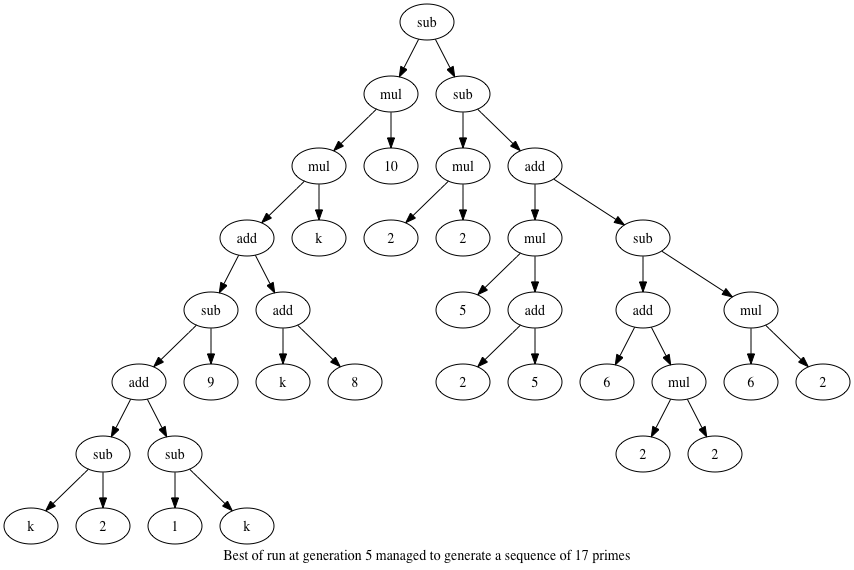

k = 0 produces 29 prime = True
k = 1 produces 19 prime = True
k = 2 produces 29 prime = True
k = 3 produces 59 prime = True
k = 4 produces 109 prime = True
k = 5 produces 179 prime = True
k = 6 produces 269 prime = True
k = 7 produces 379 prime = True
k = 8 produces 509 prime = True
k = 9 produces 659 prime = True
k = 10 produces 829 prime = True
k = 11 produces 1019 prime = True
k = 12 produces 1229 prime = True
k = 13 produces 1459 prime = True
k = 14 produces 1709 prime = True
k = 15 produces 1979 prime = True
k = 16 produces 2269 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 18.936
Longest prime sequence of inital population = 3
Percentage of initial population that generate a prime from first k value = 10.5%

.:: Starting breedin

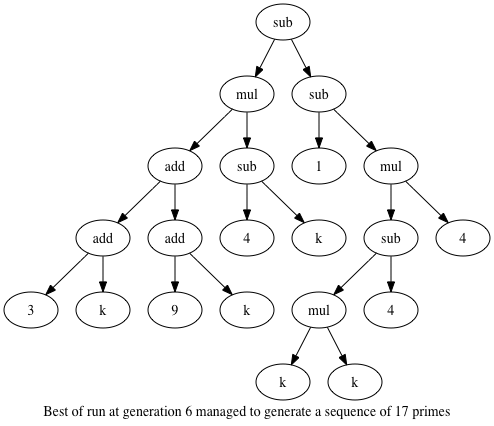

k = 0 produces 31 prime = True
k = 1 produces 29 prime = True
k = 2 produces 31 prime = True
k = 3 produces 37 prime = True
k = 4 produces 47 prime = True
k = 5 produces 61 prime = True
k = 6 produces 79 prime = True
k = 7 produces 101 prime = True
k = 8 produces 127 prime = True
k = 9 produces 157 prime = True
k = 10 produces 191 prime = True
k = 11 produces 229 prime = True
k = 12 produces 271 prime = True
k = 13 produces 317 prime = True
k = 14 produces 367 prime = True
k = 15 produces 421 prime = True
k = 16 produces 479 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)
.:: Initialising Genetic Program ::.
Raw fitness target is 17
We will be using the TOURNAMENT selection method

Starting population is 1000
Smallest tree size is 7
Biggest tree size is 47
Mean tree size is 19.28
Longest prime sequence of inital population = 4
Percentage of initial population that generate a prime from first k value = 9.8%

.:: Starting breeding program :

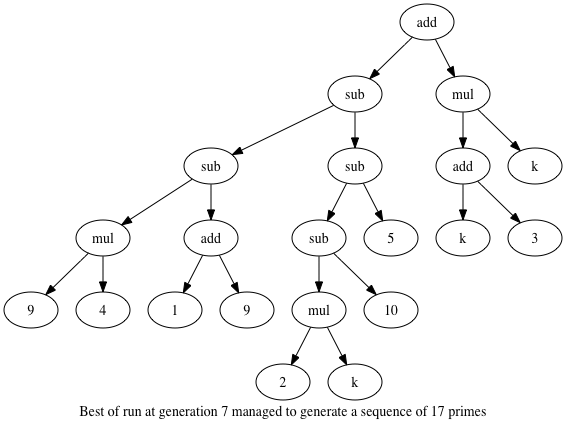

k = 0 produces 41 prime = True
k = 1 produces 43 prime = True
k = 2 produces 47 prime = True
k = 3 produces 53 prime = True
k = 4 produces 61 prime = True
k = 5 produces 71 prime = True
k = 6 produces 83 prime = True
k = 7 produces 97 prime = True
k = 8 produces 113 prime = True
k = 9 produces 131 prime = True
k = 10 produces 151 prime = True
k = 11 produces 173 prime = True
k = 12 produces 197 prime = True
k = 13 produces 223 prime = True
k = 14 produces 251 prime = True
k = 15 produces 281 prime = True
k = 16 produces 313 prime = True

Confirmed raw fitness is 17

Adjusted fitness of best is 1.0/1 (higher is better)


In [22]:
for run in range(number_of_runs):

    print(".:: Initialising Genetic Program ::.")
    print("Raw fitness target is " + str(len(userinput)))
    print("We will be using the " + selection_meth + " selection method\n")
    population = init_population()
    print("Starting population is " + population_count())
    print("Smallest tree size is " + min_pop_tree_size())
    print("Biggest tree size is " + max_pop_tree_size())
    print("Mean tree size is " + mean_pop_tree_size())
    best_of_run = None
    best_of_run_f = 0
    best_of_run_gen = 0
    fitnesses = []
    for individual in population:
        fitnesses.append(fitness(individual))
    print("Longest prime sequence of inital population = " + str(max(fitnesses)))
    print("Percentage of initial population that generate a prime from first k value = " + str(percentage_pop_are_prime_generators()) + "%\n")
    print(".:: Starting breeding program ::.")

    for gen in range(generations):        
        nextgen_population=[]
        for i in range(pop_size):
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            parent1.crossover(parent2)
            parent1.mutation()
            nextgen_population.append(parent1)
        population = nextgen_population
        fitnesses = []
        for individual in population:
            fitnesses.append(fitness(individual))
        if max(fitnesses) > best_of_run_f:
            best_of_run_f = max(fitnesses)
            best_of_run_gen = gen
            best_of_run = deepcopy(population[fitnesses.index(max(fitnesses))])
            print("Generation:", gen, "Best fitness so far:", max(fitnesses)) 
            #best_of_run.print_tree()
        if best_of_run_f == how_many_primes: break

    print("_________________________________________________\nEND OF BREEDING PROGRAM\nThe best run was attained at generation " + str(best_of_run_gen) +\
              " and has a raw fitness of " + str(best_of_run_f) + " out of " + str(len(userinput)))

    print("Program ran for " + str(gen+1) + " generations")
    GPTree.draw_tree(best_of_run, "best of run", "Best of run at generation " + str(best_of_run_gen) + " managed to generate a sequence of " + str(best_of_run_f) + " primes" )
    best_of_run_validate()
    print("\nConfirmed raw fitness is " + str(best_of_fitness()))
    print("\nAdjusted fitness of best is " + str(round(adj_fitness_best(), 2)) + "/1 (higher is better)")
    raw_fitnesses.append(best_of_run_f)
    best_of_gen.append(best_of_run_gen)
    

_________________________________________________

.:: Run Info ::.
Run used TOURNAMENT selection method
Starting population was 1000
Program was run 50 times with 10 generations per run
Percentage of runs that generated the full list of 17 primes 82.0%
Mean best of run occurance was in generation 3.86


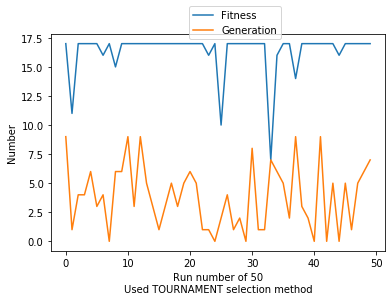

<Figure size 1080x1080 with 0 Axes>

In [23]:
run_info()